<a href="https://colab.research.google.com/github/Zhangmingyang-Su/ads-project/blob/master/Click_Through_Rate_Predcition_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic: Click through rate by cold start - dataset by kaggle

## Main Procedures:
#### 1. Spark envrionment setup
#### 2. EDA
#### 3. Feature Preprocessing
#### 4. ML Model Selection
#### 5. Feature Importance
#### 6. Insight from Conclusion

##0. Spark Setup

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

     |████████████████████████████████| 204kB 4.6MB/s 


In [2]:
!ls

sample_data  spark-2.4.5-bin-hadoop2.7	spark-2.4.5-bin-hadoop2.7.tgz


In [3]:
!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)

/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory


In [4]:
! echo $JAVA_HOME

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext.getOrCreate()

sqlContext = SQLContext(sc)

In [7]:
spark.version

'2.4.5'

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## *. Read data from local machine

In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving filtered_train.csv to filtered_train.csv
User uploaded file "filtered_train.csv" with length 67056673 bytes


In [11]:
!ls

filtered_train.csv  spark-2.4.5-bin-hadoop2.7
sample_data	    spark-2.4.5-bin-hadoop2.7.tgz


In [12]:
import os 
os.listdir('./sample_data')

['anscombe.json',
 'README.md',
 'mnist_test.csv',
 'mnist_train_small.csv',
 'california_housing_train.csv',
 'california_housing_test.csv']

##1. EDA

In [0]:
impression = spark.read.csv("filtered_train.csv", inferSchema=True, header=True )

In [14]:
impression.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)



In [15]:
impression.show()

+------+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+
|   _c0|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|
+------+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+
|128037|1.107450855228460...|    0|14102101|1005|         1|e151e245|   7e091613|     f028772b|ecad2386|  7801e8d9|    07d7df22| a99f214a| 10dcdfb1|    88fe1d5d|          1|               0|20352|320| 50|2333|  0|  39|    -1|157|
|491755|1.240012241576984...|    0|14102103|1005|         0|1fbe01fe|   f3845767

In [16]:
print("impression size: " + str(impression.count()))

impression size: 404290


In [0]:
# sql temp view
impression.createOrReplaceTempView("impression")

###1.1. Banner Position

In [18]:
# Banner Position for SQL
Banner_position = spark.sql('''select banner_pos, 
                               count(*) as nums 
                               from impression 
                               group by 1 
                               order by 1''')
Banner_position.show()

+----------+------+
|banner_pos|  nums|
+----------+------+
|         0|291180|
|         1|112416|
|         2|   111|
|         3|    20|
|         4|    69|
|         5|    57|
|         7|   437|
+----------+------+



In [0]:
# from spark sql to Pandas Dataframe
Banner_position_df = Banner_position.toPandas()

<Figure size 432x288 with 0 Axes>

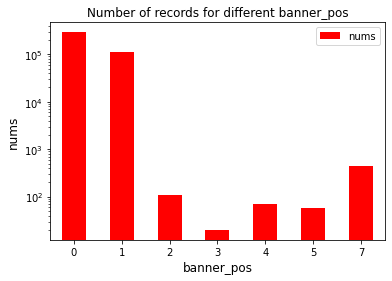

In [20]:
import matplotlib.pyplot as plt

# data visualization
plt.figure()
ax = Banner_position_df.plot(kind = 'bar', x = 'banner_pos', y = 'nums', logy = True, color = 'red', legend = True, align = 'center')
ax.set_xlabel('banner_pos', fontsize = 12)
ax.set_ylabel('nums', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of records for different banner_pos')
display()

###1.2. click and no_click numbers by Banner Position

In [21]:
click_no_click = spark.sql('''select banner_pos, 
                              sum(case when click = 1 then 1 else 0 end) as click, 
                              sum(case when click = 0 then 1 else 0 end) as no_click 
                              from impression 
                              group by 1 
                              order by 1''')
click_no_click.show()

+----------+-----+--------+
|banner_pos|click|no_click|
+----------+-----+--------+
|         0|47939|  243241|
|         1|20542|   91874|
|         2|   12|      99|
|         3|    5|      15|
|         4|   12|      57|
|         5|    6|      51|
|         7|  139|     298|
+----------+-----+--------+



In [0]:
# from spark sql to Pandas Dataframe
click_no_click_df = click_no_click.toPandas()

<Figure size 432x288 with 0 Axes>

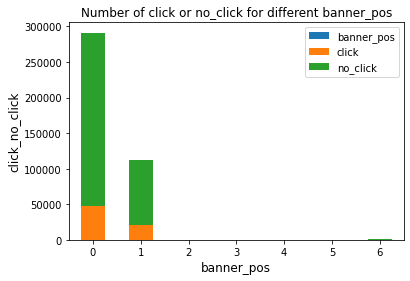

In [23]:
# data visualization
plt.figure()
ax = click_no_click_df.plot(kind = 'bar', stacked=True)
ax.set_xlabel('banner_pos', fontsize = 12)
ax.set_ylabel('click_no_click', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of click or no_click for different banner_pos')
display()

###1.3. CTR by Banner Position

In [24]:
ctr_pos = spark.sql('''select banner_pos,
                       sum(case when click = 1 then 1 else 0 end) / count(*) as ctr
                       from impression
                       group by 1
                       order by 1''')
ctr_pos.show()

+----------+-------------------+
|banner_pos|                ctr|
+----------+-------------------+
|         0|  0.164636994299059|
|         1|0.18273199544548818|
|         2|0.10810810810810811|
|         3|               0.25|
|         4|0.17391304347826086|
|         5|0.10526315789473684|
|         7| 0.3180778032036613|
+----------+-------------------+



In [0]:
# from spark sql to Pandas Dataframe
ctr_pos_df = ctr_pos.toPandas()

<Figure size 432x288 with 0 Axes>

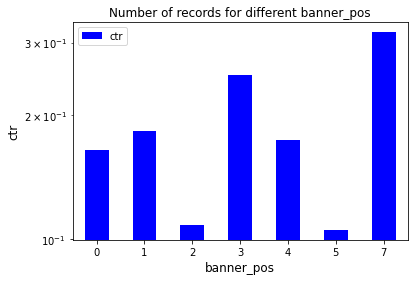

In [26]:
# data visualization
plt.figure()
ax = ctr_pos_df.plot(kind = 'bar', x = 'banner_pos', y = 'ctr', logy = True, color = 'blue', legend = True, align = 'center')
ax.set_xlabel('banner_pos', fontsize = 12)
ax.set_ylabel('ctr', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of records for different banner_pos')
display()

###1.4. device_type

In [27]:
device_type = spark.sql('''select device_type,
                           count(*) as nums
                           from impression
                           group by 1
                           order by 1''')
device_type.show()

+-----------+------+
|device_type|  nums|
+-----------+------+
|          0| 22063|
|          1|373227|
|          4|  7703|
|          5|  1297|
+-----------+------+



In [0]:
# from spark sql to Pandas Dataframe
device_type_df = device_type.toPandas()

<Figure size 432x288 with 0 Axes>

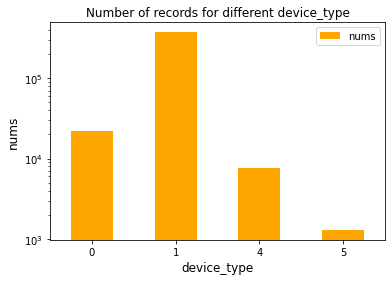

In [29]:
# data visualization
plt.figure()
ax = device_type_df.plot(kind = 'bar', x = 'device_type', y = 'nums', logy = True, color = 'orange', legend = True, align = 'center')
ax.set_xlabel('device_type', fontsize = 12)
ax.set_ylabel('nums', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of records for different device_type')
display()

###1.5. click and no_click numbers by device_type

In [30]:
device_type_click_no_click = spark.sql('''select device_type,
                                          sum(case when click = 1 then 1 else 0 end) as click,
                                          sum(case when click = 0 then 1 else 0 end) as no_click
                                          from impression
                                          group by 1
                                          order by 1''')
device_type_click_no_click.show()

+-----------+-----+--------+
|device_type|click|no_click|
+-----------+-----+--------+
|          0| 4781|   17282|
|          1|63033|  310194|
|          4|  731|    6972|
|          5|  110|    1187|
+-----------+-----+--------+



In [0]:
# from spark sql to Pandas Dataframe
device_type_click_no_click_df = device_type_click_no_click.toPandas()

<Figure size 432x288 with 0 Axes>

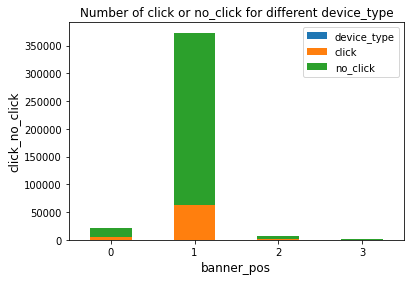

In [32]:
# data visualization
plt.figure()
ax = device_type_click_no_click_df.plot(kind = 'bar', stacked=True)
ax.set_xlabel('banner_pos', fontsize = 12)
ax.set_ylabel('click_no_click', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of click or no_click for different device_type')
display()

###1.6. CTR by device_type

In [33]:
ctr_device_type = spark.sql('''select device_type,
                               sum(case when click = 1 then 1 else 0 end) / count(*) as ctr
                               from impression
                               group by 1
                               order by 1''')
ctr_device_type.show()

+-----------+-------------------+
|device_type|                ctr|
+-----------+-------------------+
|          0|0.21669763858042876|
|          1|0.16888649535001488|
|          4|0.09489809165260288|
|          5|0.08481110254433308|
+-----------+-------------------+



In [0]:
# from spark sql to Pandas Dataframe
ctr_device_type_df = ctr_device_type.toPandas()

<Figure size 432x288 with 0 Axes>

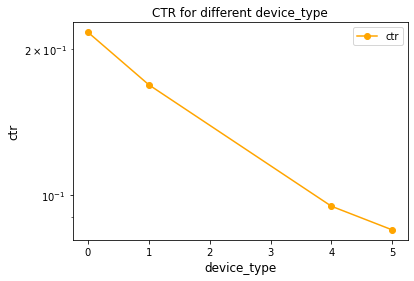

In [35]:
plt.figure()
ax = ctr_device_type_df.plot(kind = 'line', x = 'device_type', y = 'ctr', logy = True, color = 'orange', marker= 'o', legend = True)
ax.set_xlabel('device_type', fontsize = 12)
ax.set_ylabel('ctr', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.yticks(fontsize=10, rotation = 0)
plt.title('CTR for different device_type')
display()

###1.7. Site Category

In [36]:
site_category = spark.sql('''select site_category,
                             count(*) as nums
                             from impression
                             group by 1
                             having nums > 200
                             order by 2 desc''')
site_category.show()

+-------------+------+
|site_category|  nums|
+-------------+------+
|     50e219e0|165632|
|     f028772b|126494|
|     28905ebd| 73611|
|     3e814130| 30335|
|     f66779e6|  2548|
|     75fa27f6|  1662|
|     335d28a8|  1339|
|     76b2941d|  1107|
|     c0dd3be3|   426|
|     72722551|   287|
|     dedf689d|   265|
|     70fb0e29|   251|
+-------------+------+



In [0]:
# from spark sql to Pandas Dataframe
site_category_df = site_category.toPandas()

<Figure size 432x288 with 0 Axes>

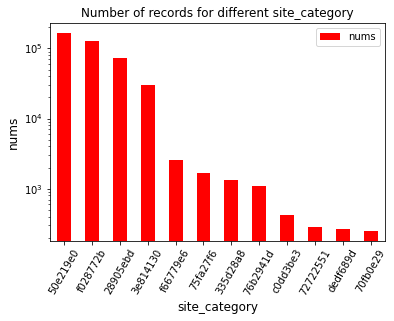

In [38]:
# data visualization
plt.figure()
ax = site_category_df.plot(kind = 'bar', x = 'site_category', y = 'nums', logy = True, color = 'red', legend = True, align = 'center')
ax.set_xlabel('site_category', fontsize = 12)
ax.set_ylabel('nums', fontsize = 12)
plt.xticks(fontsize=10, rotation = 60)
plt.title('Number of records for different site_category')
display()

###1.8. click and no_click numbers by different Site Category

In [39]:
site_category_click_no_click = spark.sql('''select site_category,
                                            sum(case when click = 1 then 1 else 0 end) as click,
                                            sum(case when click = 0 then 1 else 0 end) as no_click
                                            from impression
                                            group by 1
                                            order by 3 desc''')
site_category_click_no_click.show()

+-------------+-----+--------+
|site_category|click|no_click|
+-------------+-----+--------+
|     50e219e0|21349|  144283|
|     f028772b|22664|  103830|
|     28905ebd|15399|   58212|
|     3e814130| 8536|   21799|
|     f66779e6|  118|    2430|
|     75fa27f6|  175|    1487|
|     335d28a8|  117|    1222|
|     76b2941d|   23|    1084|
|     c0dd3be3|   51|     375|
|     72722551|   26|     261|
|     70fb0e29|   43|     208|
|     0569f928|    6|     155|
|     dedf689d|  135|     130|
|     8fd0aea4|    2|      72|
|     a818d37a|    0|      28|
|     42a36e14|    9|      28|
|     bcf865d9|    0|      14|
|     e787de0e|    0|      10|
|     5378d028|    2|       4|
|     c706e647|    0|       1|
+-------------+-----+--------+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
site_category_click_no_click_df = site_category_click_no_click.toPandas()

<Figure size 432x288 with 0 Axes>

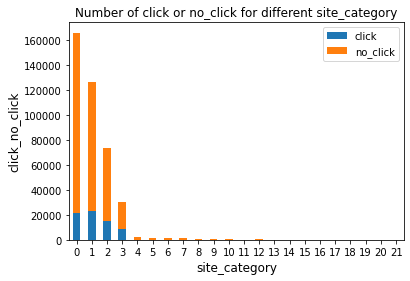

In [41]:
# data visualization
plt.figure()
ax = site_category_click_no_click_df.plot(kind = 'bar', stacked=True)
ax.set_xlabel('site_category', fontsize = 12)
ax.set_ylabel('click_no_click', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of click or no_click for different site_category')
display()

###1.9. CTR by Site Category

In [42]:
ctr_site_category = spark.sql('''select site_category,
                                 sum(case when click = 1 then 1 else 0 end) / count(*) as ctr
                                 from impression
                                 group by 1
                                 order by 2 desc''')
ctr_site_category.show()

+-------------+--------------------+
|site_category|                 ctr|
+-------------+--------------------+
|     dedf689d|  0.5094339622641509|
|     5378d028|  0.3333333333333333|
|     3e814130|  0.2813911323553651|
|     42a36e14| 0.24324324324324326|
|     28905ebd|  0.2091942780290989|
|     f028772b| 0.17917055354404163|
|     70fb0e29| 0.17131474103585656|
|     50e219e0| 0.12889417503863987|
|     c0dd3be3| 0.11971830985915492|
|     75fa27f6| 0.10529482551143202|
|     72722551| 0.09059233449477352|
|     335d28a8| 0.08737864077669903|
|     f66779e6| 0.04631083202511774|
|     0569f928|0.037267080745341616|
|     8fd0aea4| 0.02702702702702703|
|     76b2941d| 0.02077687443541102|
|     bcf865d9|                 0.0|
|     9ccfa2ea|                 0.0|
|     e787de0e|                 0.0|
|     c706e647|                 0.0|
+-------------+--------------------+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
ctr_site_category_df = ctr_site_category.toPandas()

<Figure size 432x288 with 0 Axes>

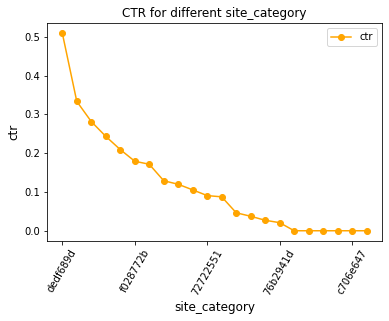

In [44]:
# visualization
plt.figure()
ax = ctr_site_category_df.plot(kind = 'line', x = 'site_category', y = 'ctr', logy = False, color = 'orange', marker= 'o', legend = True)
ax.set_xlabel('site_category', fontsize = 12)
ax.set_ylabel('ctr', fontsize = 12)
plt.xticks(fontsize=10, rotation = 60)
plt.yticks(fontsize=10, rotation = 0)
plt.title('CTR for different site_category')
display()

###1.10. Hour of Day

In [45]:
hour_day = spark.sql('''select substr(hour, 7) as hour,
                        count(*) as nums
                        from impression
                        group by 1
                        order by 1''')
hour_day.show()

+----+-----+
|hour| nums|
+----+-----+
|  00| 8531|
|  01| 9928|
|  02|12282|
|  03|14112|
|  04|18990|
|  05|19625|
|  06|17741|
|  07|18637|
|  08|20991|
|  09|22747|
|  10|21362|
|  11|20585|
|  12|22253|
|  13|23907|
|  14|21943|
|  15|20863|
|  16|20252|
|  17|20547|
|  18|17674|
|  19|13180|
+----+-----+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
hour_day_df = hour_day.toPandas()

<Figure size 432x288 with 0 Axes>

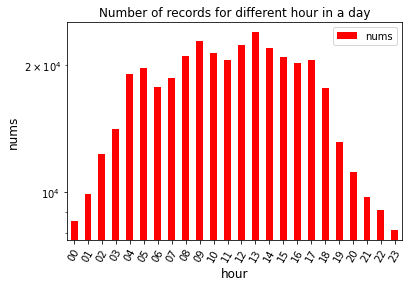

In [47]:
# data visualization
plt.figure()
ax = hour_day_df.plot(kind = 'bar', x = 'hour', y = 'nums', logy = True, color = 'red', legend = True, align = 'center')
ax.set_xlabel('hour', fontsize = 12)
ax.set_ylabel('nums', fontsize = 12)
plt.xticks(fontsize=10, rotation = 60)
plt.title('Number of records for different hour in a day')
display()

###1.11 click and no_click numbers by different hour of a day

In [48]:
hour_day_click_no_click = spark.sql('''select substr(hour, 7) as hour,
                                       sum(case when click = 1 then 1 else 0 end) as click,
                                       sum(case when click = 0 then 1 else 0 end) as no_click
                                       from impression
                                       group by 1
                                       order by 1''')
hour_day_click_no_click.show()

+----+-----+--------+
|hour|click|no_click|
+----+-----+--------+
|  00| 1572|    6959|
|  01| 1811|    8117|
|  02| 2134|   10148|
|  03| 2436|   11676|
|  04| 3089|   15901|
|  05| 3193|   16432|
|  06| 3058|   14683|
|  07| 3346|   15291|
|  08| 3387|   17604|
|  09| 3591|   19156|
|  10| 3429|   17933|
|  11| 3534|   17051|
|  12| 3870|   18383|
|  13| 3982|   19925|
|  14| 3836|   18107|
|  15| 3849|   17014|
|  16| 3593|   16659|
|  17| 3596|   16951|
|  18| 2959|   14715|
|  19| 2101|   11079|
+----+-----+--------+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
hour_day_click_no_click_df = hour_day_click_no_click.toPandas()

<Figure size 432x288 with 0 Axes>

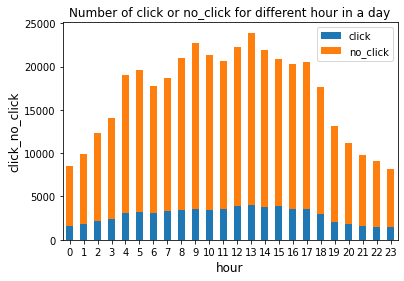

In [50]:
# data visualization
plt.figure()
ax = hour_day_click_no_click_df.plot(kind = 'bar', stacked=True)
ax.set_xlabel('hour', fontsize = 12)
ax.set_ylabel('click_no_click', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of click or no_click for different hour in a day')
display()

###1.11. CTR by hour of a day

In [51]:
ctr_hour_day = spark.sql('''select substr(hour, 7) as hour,
                            sum(case when click = 1 then 1 else 0 end) / count(*) as ctr
                            from impression
                            group by 1
                            order by 1''')
ctr_hour_day.show()

+----+-------------------+
|hour|                ctr|
+----+-------------------+
|  00|0.18426913609190013|
|  01| 0.1824133763094279|
|  02|0.17375020354991044|
|  03|0.17261904761904762|
|  04|0.16266456029489204|
|  05|0.16270063694267517|
|  06|0.17236908855194183|
|  07|0.17953533293985083|
|  08|0.16135486637130197|
|  09| 0.1578669714687651|
|  10|0.16051867802640202|
|  11| 0.1716784066067525|
|  12| 0.1739091358468521|
|  13|0.16656209478395448|
|  14|0.17481657020462107|
|  15|0.18448928725494895|
|  16|0.17741457633813945|
|  17|  0.175013383948995|
|  18|0.16742107049903812|
|  19| 0.1594081942336874|
+----+-------------------+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
ctr_hour_day_df = ctr_hour_day.toPandas()

<Figure size 432x288 with 0 Axes>

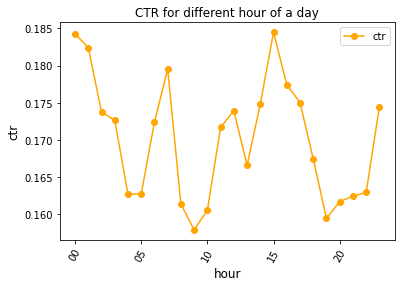

In [53]:
# visualization
plt.figure()
ax = ctr_hour_day_df.plot(kind = 'line', x = 'hour', y = 'ctr', logy = False, color = 'orange', marker= 'o', legend = True)
ax.set_xlabel('hour', fontsize = 12)
ax.set_ylabel('ctr', fontsize = 12)
plt.xticks(fontsize=10, rotation = 60)
plt.yticks(fontsize=10, rotation = 0)
plt.title('CTR for different hour of a day')
display()

###1.12. Cardinality of distinct column values


In [54]:
cardinality_distinct_values = spark.sql('''
                                            select 
                                            count(*) as total,

                                            count(distinct C1) as C1,
                                            count(distinct banner_pos) as banner_pos,
                                            count(distinct site_id) as site_id,
                                            count(distinct site_domain) as site_domain,
                                            count(distinct site_category) as site_category,
                                            count(distinct app_id) as app_id,
                                            count(distinct app_domain) as app_domain,
                                            count(distinct app_category) as app_category,
                                            count(distinct device_id) as device_id,
                                            count(distinct device_ip) as device_ip,
                                            count(distinct device_model) as device_model,
                                            count(distinct device_type) as device_type,
                                            count(distinct device_conn_type) as device_conn_type,
                                            count(distinct C14) as C14,
                                            count(distinct C15) as C15,
                                            count(distinct C16) as C16,
                                            count(distinct C17) as C17,
                                            count(distinct C18) as C18,
                                            count(distinct C19) as C19,
                                            count(distinct C20) as C20,
                                            count(distinct C21) as C21
                                            from impression''')

cardinality_distinct_values.show()

+------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+
| total| C1|banner_pos|site_id|site_domain|site_category|app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type| C14|C15|C16|C17|C18|C19|C20|C21|
+------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+
|404290|  7|         7|   2225|       2188|           22|  2241|       143|          27|    64742|   261706|        4380|          4|               4|2088|  8|  9|411|  4| 65|161| 60|
+------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+



In [55]:
impression.describe().show()

+-------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|                 _c0|                  id|              click|                hour|                C1|        banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|       device_type|  device_conn_type|              C14|               C15|               C16|               C17|               C18|               C19|              C20|              C21|
+-------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+--------+-----------+-----------

##2. Data Preprocessing
Advertising Analytics Click Prediction: ML
####[Ad impressions with clicks dataset](https://www.kaggle.com/c/avazu-ctr-prediction/data)

<img src="/files/img/fraud_ml_pipeline.png" alt="workflow" width="500">

For this stage, we will focus on creating features and training and evaluating the ML model.

<img src="https://s3-us-west-2.amazonaws.com/pub-tc/ML-workflow.png" width="800">



In [0]:
# numbers of distinct values per column
from pyspark.sql.functions import *

strCols = map(lambda t: t[0], filter(lambda t: t[1] == 'string', impression.dtypes))
intCols = map(lambda t: t[0], filter(lambda t: t[1] == 'int', impression.dtypes))

# [row_idx][json_idx]
strColsCount = sorted(map(lambda c: (c, impression.select(countDistinct(c)).collect()[0][0]), strCols), key=lambda x: x[1], reverse=True)
intColsCount = sorted(map(lambda c: (c, impression.select(countDistinct(c)).collect()[0][0]), intCols), key=lambda x: x[1], reverse=True)

In [57]:
# distinct counts for str columns
display(strColsCount)

[('device_ip', 261706),
 ('device_id', 64742),
 ('device_model', 4380),
 ('app_id', 2241),
 ('site_id', 2225),
 ('site_domain', 2188),
 ('app_domain', 143),
 ('app_category', 27),
 ('site_category', 22)]

In [58]:
# distinct counts for int columns
display(intColsCount)

[('_c0', 402586),
 ('C14', 2088),
 ('C17', 411),
 ('hour', 240),
 ('C20', 161),
 ('C19', 65),
 ('C21', 60),
 ('C16', 9),
 ('C15', 8),
 ('C1', 7),
 ('banner_pos', 7),
 ('device_type', 4),
 ('device_conn_type', 4),
 ('C18', 4),
 ('click', 2)]

###2.1 Prepare Features





In [0]:
# Include PySpark Feature Engineering methods
from pyspark.ml.feature import StringIndexer, VectorAssembler

# All of the columns (string or integer) are categorical columns
# except for the [click] column
maxBins = 70
categorical = list(map(lambda c: c[0], filter(lambda c: c[1] <= maxBins, strColsCount)))
categorical += list(map(lambda c: c[0], filter(lambda c: c[1] <= maxBins, intColsCount)))
categorical.remove('click')

# Apply string indexer to all of the categorical columns
# And add _idx to the column name to indicate the index of the categorical value
stringIndexers = list(map(lambda c: StringIndexer(inputCol = c, outputCol = c + "_idx"), categorical))

# Assemble the put as the input to the VectorAssembler 
# with the output being our features
assemblerInputs = list(map(lambda c: c + "_idx", categorical))
vectorAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")

# The [click] column is our label 
labelStringIndexer = StringIndexer(inputCol = "click", outputCol = "label")

# The stages of our ML pipeline 
stages = stringIndexers + [vectorAssembler, labelStringIndexer]

In [0]:
from pyspark.ml import Pipeline

# Create our pipeline
pipeline = Pipeline(stages = stages)

# create transformer to add features
featurizer = pipeline.fit(impression)

In [0]:
# dataframe with feature and intermediate transformation columns appended
featurizedImpressions = featurizer.transform(impression)

In [85]:
featurizedImpressions.show()

+------+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+----------------+-----------------+-------+-------+-------+-------+------+--------------+---------------+--------------------+-------+--------------------+-----+
|   _c0|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|app_category_idx|site_category_idx|C19_idx|C21_idx|C16_idx|C15_idx|C1_idx|banner_pos_idx|device_type_idx|device_conn_type_idx|C18_idx|            features|label|
+------+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+

In [62]:
# feature and label columns
featurizedImpressions.select('features', 'label').show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(11,[1,2,3,7],[1....|  0.0|
|(11,[1,3],[2.0,2.0])|  0.0|
|(11,[1,2,3,7,10],...|  0.0|
|(11,[1,2,7,10],[1...|  0.0|
|(11,[1,2,3,7,10],...|  1.0|
|(11,[1,2,3,7,10],...|  0.0|
|(11,[1,2,3,10],[3...|  0.0|
|(11,[0,3,9],[2.0,...|  0.0|
|(11,[1,3],[2.0,2.0])|  1.0|
|(11,[1,3],[2.0,2.0])|  0.0|
|(11,[1,2,3,4,5,10...|  1.0|
|(11,[0,2,3,10],[1...|  0.0|
|(11,[1,3,7,10],[2...|  0.0|
|(11,[2,3,6,8,10],...|  0.0|
|(11,[0,3,9],[2.0,...|  0.0|
|(11,[1,3,7],[1.0,...|  0.0|
|(11,[1,3,7,10],[6...|  0.0|
|(11,[1,2,3,7],[1....|  1.0|
|(11,[1,2,3],[3.0,...|  0.0|
|(11,[1,2,3,10],[1...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [63]:
# split train and test data
train, test = featurizedImpressions \
  .select(["label", "features", "hour"]) \
  .randomSplit([0.7, 0.3], 42)
train.cache()
test.cache()

DataFrame[label: double, features: vector, hour: int]

##3. Model Selection

###3.1 Logistic Regression

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(labelCol="label", featuresCol="features")
lrModel = lr.fit(train)

In [0]:
# Bulid hyperparameter 
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.05, 0.3])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [0]:
# using BinaryClassification Evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [0]:
# Create 5-fold CrossValidator
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations
lr_cvModel = lr_cv.fit(train)

In [68]:
#Extract best model from the tuning exercise using ParamGridBuilder
predictions = lr_cvModel.transform(test)
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error for logistic regression = " + str(rmse))

Root-mean-square error for logistic regression = 0.6017870307085013


###3.2 Gradient-Boosted Tree

In [0]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxBins=maxBins)
gbt_Model = gbt.fit(train)

In [0]:
# apply the hyperparameter
gbt_paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [3, 5, 7])
             .addGrid(gbt.maxBins, [70, 100])
             .addGrid(gbt.maxIter, [5, 10])
             .build())

In [0]:
# evaluate model
gbt_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [0]:
# Create 5-fold CrossValidator
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_paramGrid, evaluator=gbt_evaluator, numFolds=5)

# Run cross validations. 
gbt_cvModel = gbt_cv.fit(train)

In [73]:
#Extract best model from the tuning exercise using ParamGridBuilder
predictions = gbt_cvModel.transform(test)
rmse = gbt_evaluator.evaluate(predictions)
print("Root-mean-square error for gradient-boosted tree = " + str(rmse))

Root-mean-square error for gradient-boosted tree = 0.7014789262119616


##4. Model Apply and Evaluation

###4.1 Logistic Regression Model Apply

In [0]:
#Generate predictions and evaluate using RMSE
lr_best_model = lr_cvModel.bestModel
predictions=lr_best_model.transform(test)
lr_rmse = evaluator.evaluate(predictions)

In [75]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(lr_rmse))
print ("**Best Model**")
print (" MaxIter:"+str(lr_best_model._java_obj.parent().getMaxIter())), 
print (" RegParam:"+str(lr_best_model._java_obj.parent().getRegParam()))

RMSE = 0.6017870307085014
**Best Model**
 MaxIter:10
 RegParam:0.01


In [76]:
# apply for all the dataset
lr_alldata=lr_best_model.transform(featurizedImpressions)
rmse = evaluator.evaluate(lr_alldata)
print ("RMSE for logistic regression = "+str(rmse))

RMSE for logistic regression = 0.6014692921171313


###4.2 Gradient-boosted Tree Model Apply

In [0]:
#Generate predictions and evaluate using RMSE
gbt_best_model = gbt_cvModel.bestModel
predictions=gbt_best_model.transform(test)
gbt_rmse = evaluator.evaluate(predictions)

In [78]:
#Print evaluation metrics and model parameters
print ("RMSE = "+str(gbt_rmse))
print ("**Best Model**")
print (" MaxIter:"+str(gbt_best_model._java_obj.parent().getMaxIter())), 
print (" MaxDepth:"+str(gbt_best_model._java_obj.parent().getMaxDepth()))
print (" MaxBins:"+str(gbt_best_model._java_obj.parent().getMaxBins()))

RMSE = 0.7014789262119612
**Best Model**
 MaxIter:10
 MaxDepth:7
 MaxBins:70


In [79]:
# apply for all the dataset
gbt_alldata=gbt_best_model.transform(featurizedImpressions)
rmse = gbt_evaluator.evaluate(gbt_alldata)
print ("RMSE for gradient-boosted tree = "+str(rmse))

RMSE for gradient-boosted tree = 0.7052255209024861


##5. Feature Importance

###5.1 gradient-boosted tree feature importance

In [80]:
import pandas as pd
# udf for feature importance extraction
def ExtractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))
  
  
#ExtractFeatureImportance(model.stages[-1].featureImportances, dataset, "features")
gbt_data = ExtractFeatureImportance(gbt_best_model.featureImportances, featurizedImpressions, "features")
gbt_data = sqlContext.createDataFrame(gbt_data)
gbt_data.show()

+--------------------+---+--------------------+--------------------+
|                vals|idx|                name|               score|
+--------------------+---+--------------------+--------------------+
|[23, 221, 79, 48,...|  3|             C21_idx| 0.43955101076782127|
|[35, 39, 167, 161...|  2|             C19_idx| 0.15255249741255622|
|[50e219e0, f02877...|  1|   site_category_idx| 0.10390255944448683|
|[07d7df22, 0f2161...|  0|    app_category_idx| 0.07667614439530239|
|[0, 1, 7, 2, 4, 5...|  7|      banner_pos_idx| 0.05502869513534826|
|        [0, 3, 2, 1]| 10|             C18_idx| 0.04378165097482033|
|[50, 250, 36, 480...|  4|             C16_idx| 0.03958583385408879|
|[1005, 1002, 1010...|  6|              C1_idx| 0.03397947176057807|
|        [0, 2, 3, 5]|  9|device_conn_type_idx| 0.03222702120263723|
|        [1, 0, 4, 5]|  8|     device_type_idx|0.011493628574925112|
|[320, 300, 216, 7...|  5|             C15_idx| 0.01122148647743547|
+--------------------+---+--------

In [0]:
# sql temp view
gbt_data.createOrReplaceTempView("gbt_data")

In [82]:
gbt_feature_importance = spark.sql('''select name as feature,
                                      score as importance_score
                                      from gbt_data
                                      order by 2 desc''')
gbt_feature_importance.show()

+--------------------+--------------------+
|             feature|    importance_score|
+--------------------+--------------------+
|             C21_idx| 0.43955101076782127|
|             C19_idx| 0.15255249741255622|
|   site_category_idx| 0.10390255944448683|
|    app_category_idx| 0.07667614439530239|
|      banner_pos_idx| 0.05502869513534826|
|             C18_idx| 0.04378165097482033|
|             C16_idx| 0.03958583385408879|
|              C1_idx| 0.03397947176057807|
|device_conn_type_idx| 0.03222702120263723|
|     device_type_idx|0.011493628574925112|
|             C15_idx| 0.01122148647743547|
+--------------------+--------------------+



In [0]:
# from spark sql to Pandas Dataframe
gbt_feature_importance_df = gbt_feature_importance.toPandas()

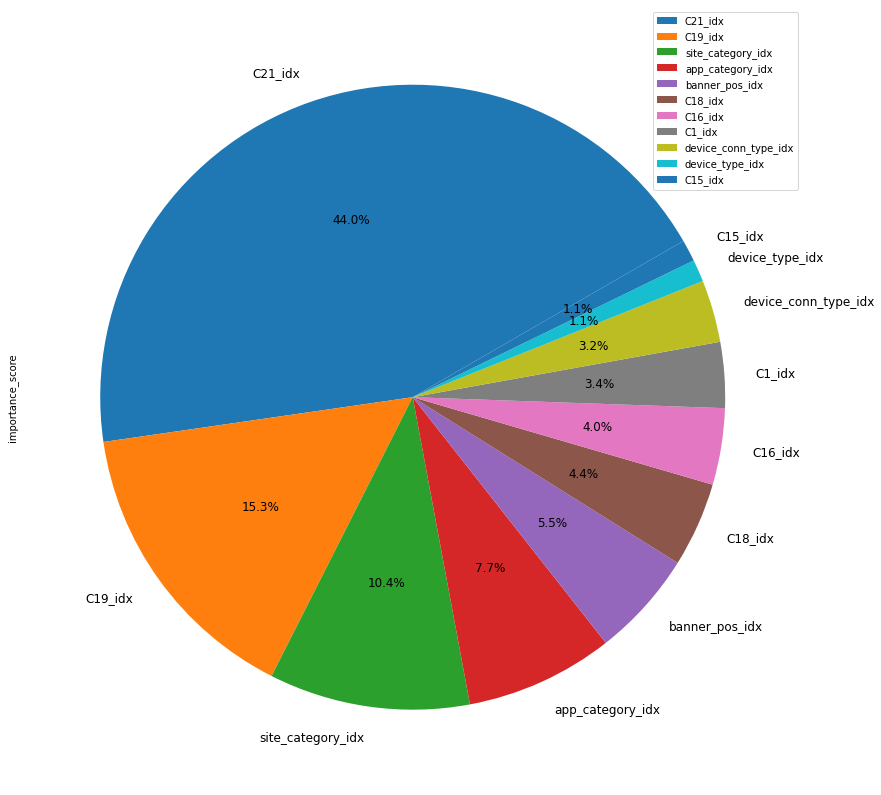

In [84]:
# data visualization
plt.figure(figsize=(14,15))
# plot chart
ax1 = plt.subplot(aspect='equal')
gbt_feature_importance_df.plot(kind='pie', y = 'importance_score', ax=ax1, autopct='%1.1f%%', 
 startangle=30, shadow=False, labels=gbt_feature_importance_df['feature'], legend = True, fontsize=12)

##6. Improve Model Performance - LR + GBDT 

## Basic LR + GBDT Model Explain



<img src="https://miro.medium.com/max/1400/1*jC5T3FeI_X8Zwa-rbf8cfg.png" width="800">

<img src="https://miro.medium.com/max/1400/1*ivIuVXL7JpnJx83DqWI9GQ.png" width="800">

<img src="https://miro.medium.com/max/1400/1*XzLBOdDH0ypuY0Ez8p9nKA.png" width="800">

